# Tutorial 20: Brain-Inspired Computing

In this tutorial, we'll explore brain-inspired computing models including Spiking Neural Networks (SNNs), neurodynamics, and biologically plausible learning rules.

## Learning Objectives

By the end of this tutorial, you will be able to:
- Build Spiking Neural Networks (SNNs)
- Implement neuron dynamics models (LIF, AdEx)
- Create synaptic plasticity rules (STDP)
- Simulate neuronal populations
- Visualize spike trains and dynamics
- Apply brain-inspired learning rules
- Build event-driven computations

## What We'll Build

We'll create:
- Leaky Integrate-and-Fire (LIF) neurons
- Spiking neural network layers
- Spike-Timing-Dependent Plasticity (STDP)
- Population coding models
- Complete SNN for classification

In [1]:
import brainstate as bst
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Optional

# Set random seed
bst.random.seed(42)

print(f"JAX devices: {jax.devices()}")

JAX devices: [CpuDevice(id=0)]


## 1. Leaky Integrate-and-Fire (LIF) Neuron

The LIF model is one of the most fundamental spiking neuron models.

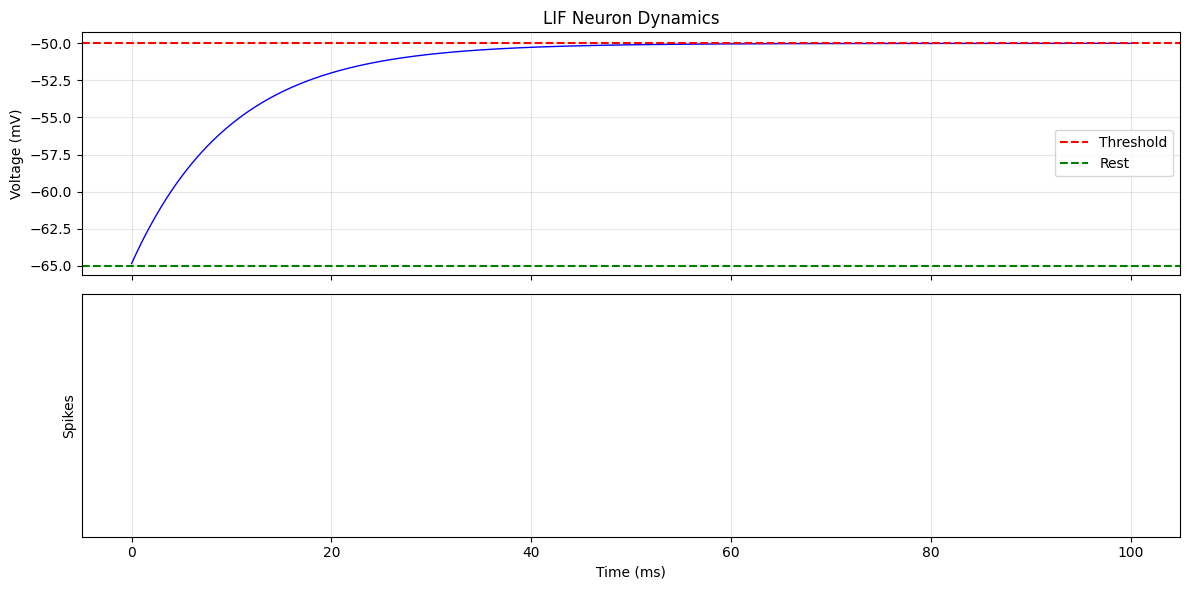

Firing rate: 0.00 Hz


In [3]:
class LIFNeuron(bst.nn.Dynamics):
    """Leaky Integrate-and-Fire neuron model.
    
    Dynamics:
        tau * dV/dt = -(V - V_rest) + R * I
        if V >= V_th: V = V_reset, emit spike
    """
    
    def __init__(
        self,
        size: int,
        tau: float = 10.0,      # Membrane time constant (ms)
        V_rest: float = -65.0,   # Resting potential (mV)
        V_reset: float = -70.0,  # Reset potential (mV)
        V_th: float = -50.0,     # Threshold potential (mV)
        R: float = 1.0,          # Membrane resistance
        dt: float = 0.1,         # Time step (ms)
    ):
        super().__init__(size)
        self.size = size
        self.tau = tau
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.R = R
        self.dt = dt
        
        # State variables
        self.V = bst.ShortTermState(jnp.ones(size) * V_rest)
        self.spike = bst.ShortTermState(jnp.zeros(size, dtype=bool))
    
    def reset_state(self):
        """Reset to resting state."""
        self.V.value = jnp.ones(self.size) * self.V_rest
        self.spike.value = jnp.zeros(self.size, dtype=bool)
    
    def __call__(self, I: jnp.ndarray) -> jnp.ndarray:
        """Update neuron state for one time step.
        
        Args:
            I: Input current of shape (size,)
            
        Returns:
            spike: Binary spike array
        """
        # Integrate membrane potential
        dV = (-(self.V.value - self.V_rest) + self.R * I) / self.tau
        V_new = self.V.value + dV * self.dt
        
        # Check for spikes
        spike = V_new >= self.V_th
        
        # Reset spiking neurons
        V_new = jnp.where(spike, self.V_reset, V_new)
        
        # Update state
        self.V.value = V_new
        self.spike.value = spike
        
        return spike.astype(jnp.float32)

# Create LIF neuron
neuron = LIFNeuron(size=1, tau=10.0, V_th=-50.0, V_reset=-70.0, dt=0.1)

# Simulate with constant input
n_steps = 1000
I_input = 15.0  # Input current

voltages = []
spikes = []

neuron.reset_state()
for t in range(n_steps):
    spike = neuron(jnp.array([I_input]))
    voltages.append(float(neuron.V.value[0]))
    spikes.append(float(spike[0]))

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

time = np.arange(n_steps) * neuron.dt

# Membrane potential
ax1.plot(time, voltages, 'b-', linewidth=1)
ax1.axhline(neuron.V_th, color='r', linestyle='--', label='Threshold')
ax1.axhline(neuron.V_rest, color='g', linestyle='--', label='Rest')
ax1.set_ylabel('Voltage (mV)')
ax1.set_title('LIF Neuron Dynamics')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Spike raster
spike_times = time[np.array(spikes) > 0]
ax2.eventplot(spike_times, colors='black', linewidths=2)
ax2.set_ylabel('Spikes')
ax2.set_xlabel('Time (ms)')
ax2.set_ylim([0.5, 1.5])
ax2.set_yticks([])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Firing rate: {np.sum(spikes) / (n_steps * neuron.dt) * 1000:.2f} Hz")

### F-I Curve (Frequency-Current Relationship)

In [ ]:
def measure_firing_rate(neuron, I_input, duration=500):
    """Measure firing rate for given input current."""
    neuron.reset_state()
    n_steps = int(duration / neuron.dt)
    spike_count = 0
    
    for _ in range(n_steps):
        spike = neuron(jnp.array([I_input]))
        spike_count += float(spike[0])
    
    # Convert to Hz
    firing_rate = spike_count / duration * 1000
    return firing_rate

# Test different input currents
currents = np.linspace(0, 30, 30)
firing_rates = []

neuron = LIFNeuron(size=1, tau=10.0, V_th=-50.0)

for I in currents:
    fr = measure_firing_rate(neuron, I)
    firing_rates.append(fr)

# Plot F-I curve
plt.figure(figsize=(10, 6))
plt.plot(currents, firing_rates, 'b-', linewidth=2)
plt.xlabel('Input Current (a.u.)')
plt.ylabel('Firing Rate (Hz)')
plt.title('F-I Curve: Frequency-Current Relationship')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Population of LIF Neurons

In [ ]:
class LIFPopulation(bst.nn.Dynamics):
    """Population of LIF neurons."""
    
    def __init__(self, size: int, **kwargs):
        super().__init__()
        self.neurons = LIFNeuron(size=size, **kwargs)
    
    def reset_state(self):
        self.neurons.reset_state()
    
    def __call__(self, I: jnp.ndarray) -> jnp.ndarray:
        return self.neurons(I)

# Create population
n_neurons = 50
population = LIFPopulation(size=n_neurons, tau=10.0, V_th=-50.0, dt=0.1)

# Simulate with random inputs
n_steps = 500
spike_trains = []

population.reset_state()
for t in range(n_steps):
    # Random input to each neuron
    I_input = bst.random.randn(n_neurons) * 5 + 15
    spikes = population(I_input)
    spike_trains.append(spikes)

spike_trains = np.array(spike_trains)  # Shape: (n_steps, n_neurons)

# Plot raster plot
plt.figure(figsize=(12, 6))

time = np.arange(n_steps) * population.neurons.dt

# Create raster plot
for neuron_idx in range(n_neurons):
    spike_times = time[spike_trains[:, neuron_idx] > 0]
    plt.plot(spike_times, np.ones_like(spike_times) * neuron_idx, 
             'k.', markersize=2)

plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title(f'Population Activity: {n_neurons} LIF Neurons')
plt.ylim([-1, n_neurons])
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Population firing rate over time
window = 10  # ms
window_steps = int(window / population.neurons.dt)
pop_rate = []

for i in range(0, n_steps - window_steps):
    rate = np.sum(spike_trains[i:i+window_steps]) / (n_neurons * window) * 1000
    pop_rate.append(rate)

plt.figure(figsize=(12, 4))
plt.plot(time[:len(pop_rate)], pop_rate, 'b-', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Population Rate (Hz)')
plt.title('Population Firing Rate')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Spiking Neural Network Layer

In [ ]:
class SpikingLayer(bst.nn.Dynamics):
    """Spiking neural network layer with synaptic connections."""
    
    def __init__(self, in_size: int, out_size: int, **neuron_kwargs):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        
        # Synaptic weights
        self.weight = bst.ParamState(
            bst.random.randn(in_size, out_size) * 0.1
        )
        
        # Output neurons
        self.neurons = LIFNeuron(size=out_size, **neuron_kwargs)
    
    def reset_state(self):
        self.neurons.reset_state()
    
    def __call__(self, input_spikes: jnp.ndarray) -> jnp.ndarray:
        """Process input spikes.
        
        Args:
            input_spikes: Binary spike array of shape (in_size,)
            
        Returns:
            output_spikes: Binary spike array of shape (out_size,)
        """
        # Compute synaptic input
        I_syn = input_spikes @ self.weight.value
        
        # Update neurons
        output_spikes = self.neurons(I_syn)
        
        return output_spikes

# Create spiking layer
layer = SpikingLayer(in_size=10, out_size=5, tau=10.0, V_th=-50.0)

# Simulate
n_steps = 200
input_spike_trains = []
output_spike_trains = []

layer.reset_state()
for t in range(n_steps):
    # Random input spikes
    input_spikes = (bst.random.uniform(0, 1, (layer.in_size,)) > 0.9).astype(jnp.float32)
    output_spikes = layer(input_spikes)
    
    input_spike_trains.append(input_spikes)
    output_spike_trains.append(output_spikes)

input_spike_trains = np.array(input_spike_trains)
output_spike_trains = np.array(output_spike_trains)

# Plot input and output
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

time = np.arange(n_steps) * layer.neurons.dt

# Input spikes
for i in range(layer.in_size):
    spike_times = time[input_spike_trains[:, i] > 0]
    ax1.plot(spike_times, np.ones_like(spike_times) * i, 'b.', markersize=3)

ax1.set_ylabel('Input Neuron')
ax1.set_title('Input Spike Trains')
ax1.set_ylim([-1, layer.in_size])
ax1.grid(True, alpha=0.3)

# Output spikes
for i in range(layer.out_size):
    spike_times = time[output_spike_trains[:, i] > 0]
    ax2.plot(spike_times, np.ones_like(spike_times) * i, 'r.', markersize=3)

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Output Neuron')
ax2.set_title('Output Spike Trains')
ax2.set_ylim([-1, layer.out_size])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Spike-Timing-Dependent Plasticity (STDP)

In [ ]:
class STDPSynapse(bst.nn.Dynamics):
    """Synapse with Spike-Timing-Dependent Plasticity.
    
    STDP rule:
    - If pre-spike before post-spike: potentiation (strengthen)
    - If post-spike before pre-spike: depression (weaken)
    """
    
    def __init__(
        self,
        in_size: int,
        out_size: int,
        tau_pre: float = 20.0,   # Pre-synaptic trace time constant
        tau_post: float = 20.0,  # Post-synaptic trace time constant
        A_plus: float = 0.01,    # LTP amplitude
        A_minus: float = 0.01,   # LTD amplitude
        w_max: float = 1.0,      # Maximum weight
        dt: float = 0.1,
    ):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.tau_pre = tau_pre
        self.tau_post = tau_post
        self.A_plus = A_plus
        self.A_minus = A_minus
        self.w_max = w_max
        self.dt = dt
        
        # Synaptic weights
        self.weight = bst.ParamState(
            bst.random.uniform(0, 0.5, (in_size, out_size))
        )
        
        # Synaptic traces
        self.trace_pre = bst.ShortTermState(jnp.zeros(in_size))
        self.trace_post = bst.ShortTermState(jnp.zeros(out_size))
    
    def reset_state(self):
        self.trace_pre.value = jnp.zeros(self.in_size)
        self.trace_post.value = jnp.zeros(self.out_size)
    
    def __call__(
        self, 
        pre_spikes: jnp.ndarray, 
        post_spikes: jnp.ndarray,
        learning: bool = True
    ) -> jnp.ndarray:
        """Update synapse with STDP.
        
        Args:
            pre_spikes: Pre-synaptic spikes of shape (in_size,)
            post_spikes: Post-synaptic spikes of shape (out_size,)
            learning: Whether to apply STDP
            
        Returns:
            Synaptic current to post-synaptic neurons
        """
        if learning:
            # Update traces
            self.trace_pre.value += (-self.trace_pre.value / self.tau_pre + pre_spikes) * self.dt
            self.trace_post.value += (-self.trace_post.value / self.tau_post + post_spikes) * self.dt
            
            # STDP weight update
            # Potentiation: pre-spike causes increase based on post trace
            dw_plus = jnp.outer(pre_spikes, self.trace_post.value) * self.A_plus
            
            # Depression: post-spike causes decrease based on pre trace
            dw_minus = jnp.outer(self.trace_pre.value, post_spikes) * self.A_minus
            
            # Update weights
            w_new = self.weight.value + dw_plus - dw_minus
            
            # Clip weights
            w_new = jnp.clip(w_new, 0, self.w_max)
            
            self.weight.value = w_new
        
        # Compute synaptic input
        I_syn = pre_spikes @ self.weight.value
        
        return I_syn

# Demonstrate STDP
stdp = STDPSynapse(in_size=1, out_size=1, A_plus=0.01, A_minus=0.01)

# Simulate STDP learning
n_steps = 1000
weight_history = []

stdp.reset_state()
for t in range(n_steps):
    # Create spike pairs with different timing
    if t % 100 < 50:  # Pre before post (potentiation)
        if t % 10 == 0:
            pre_spike = jnp.array([1.0])
        elif t % 10 == 5:
            post_spike = jnp.array([1.0])
        else:
            pre_spike = jnp.array([0.0])
            post_spike = jnp.array([0.0])
    else:  # Post before pre (depression)
        if t % 10 == 0:
            post_spike = jnp.array([1.0])
        elif t % 10 == 5:
            pre_spike = jnp.array([1.0])
        else:
            pre_spike = jnp.array([0.0])
            post_spike = jnp.array([0.0])
    
    if 'pre_spike' in locals():
        _ = stdp(pre_spike, post_spike if 'post_spike' in locals() else jnp.array([0.0]))
    
    weight_history.append(float(stdp.weight.value[0, 0]))

# Plot weight evolution
plt.figure(figsize=(12, 5))
time = np.arange(n_steps) * stdp.dt
plt.plot(time, weight_history, 'b-', linewidth=2)
plt.axvline(n_steps * stdp.dt / 2, color='r', linestyle='--', 
            label='Switch: Pre→Post to Post→Pre')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic Weight')
plt.title('STDP Learning: Weight Evolution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### STDP Learning Window

In [ ]:
def measure_stdp_window(dt_spike):
    """Measure weight change for given spike timing difference."""
    stdp = STDPSynapse(in_size=1, out_size=1, A_plus=0.01, A_minus=0.01, dt=0.1)
    stdp.reset_state()
    
    initial_weight = float(stdp.weight.value[0, 0])
    
    # Single spike pair
    if dt_spike > 0:  # Pre before post
        for t in range(abs(int(dt_spike / stdp.dt)) + 50):
            if t == 0:
                pre, post = jnp.array([1.0]), jnp.array([0.0])
            elif t == int(dt_spike / stdp.dt):
                pre, post = jnp.array([0.0]), jnp.array([1.0])
            else:
                pre, post = jnp.array([0.0]), jnp.array([0.0])
            _ = stdp(pre, post)
    else:  # Post before pre
        for t in range(abs(int(dt_spike / stdp.dt)) + 50):
            if t == 0:
                pre, post = jnp.array([0.0]), jnp.array([1.0])
            elif t == abs(int(dt_spike / stdp.dt)):
                pre, post = jnp.array([1.0]), jnp.array([0.0])
            else:
                pre, post = jnp.array([0.0]), jnp.array([0.0])
            _ = stdp(pre, post)
    
    final_weight = float(stdp.weight.value[0, 0])
    return final_weight - initial_weight

# Measure STDP window
dt_values = np.linspace(-50, 50, 21)
weight_changes = [measure_stdp_window(dt) for dt in dt_values]

# Plot STDP learning window
plt.figure(figsize=(10, 6))
plt.plot(dt_values, weight_changes, 'bo-', linewidth=2, markersize=8)
plt.axhline(0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(0, color='k', linestyle='-', linewidth=0.5)
plt.xlabel('Spike Timing Difference Δt (ms)\n(Positive = Pre before Post)')
plt.ylabel('Weight Change Δw')
plt.title('STDP Learning Window')
plt.text(20, max(weight_changes)*0.8, 'LTP\n(Potentiation)', ha='center', fontsize=12)
plt.text(-20, min(weight_changes)*0.8, 'LTD\n(Depression)', ha='center', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Complete SNN for Pattern Recognition

In [ ]:
class SpikingNetwork(bst.graph.Node):
    """Simple spiking neural network."""
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        # Layers
        self.layer1 = SpikingLayer(input_size, hidden_size, tau=10.0, V_th=-50.0)
        self.layer2 = SpikingLayer(hidden_size, output_size, tau=10.0, V_th=-50.0)
    
    def reset_state(self):
        self.layer1.reset_state()
        self.layer2.reset_state()
    
    def __call__(self, input_spikes):
        hidden_spikes = self.layer1(input_spikes)
        output_spikes = self.layer2(hidden_spikes)
        return output_spikes

# Create network
snn = SpikingNetwork(input_size=10, hidden_size=20, output_size=3)

# Generate input patterns
def generate_spike_pattern(pattern_id, n_steps=100, input_size=10):
    """Generate input spike pattern for given pattern ID."""
    spikes = []
    for t in range(n_steps):
        # Different patterns have different spike probabilities
        prob = 0.1 + 0.1 * (pattern_id + 1) * (np.sin(t / 10) + 1) / 2
        spike = (np.random.random(input_size) < prob).astype(np.float32)
        spikes.append(spike)
    return np.array(spikes)

# Simulate network with different patterns
n_patterns = 3
n_steps = 100

fig, axes = plt.subplots(n_patterns, 2, figsize=(14, 10))

for pattern_id in range(n_patterns):
    # Generate input pattern
    input_pattern = generate_spike_pattern(pattern_id, n_steps)
    
    # Simulate
    snn.reset_state()
    output_spikes_history = []
    
    for t in range(n_steps):
        output_spikes = snn(jnp.array(input_pattern[t]))
        output_spikes_history.append(output_spikes)
    
    output_spikes_history = np.array(output_spikes_history)
    
    # Plot input
    ax = axes[pattern_id, 0]
    for i in range(snn.layer1.in_size):
        spike_times = np.where(input_pattern[:, i] > 0)[0]
        ax.plot(spike_times, np.ones_like(spike_times) * i, 'b.', markersize=2)
    ax.set_ylabel('Input Neuron')
    ax.set_title(f'Pattern {pattern_id}: Input')
    ax.set_ylim([-1, snn.layer1.in_size])
    
    # Plot output
    ax = axes[pattern_id, 1]
    for i in range(snn.layer2.out_size):
        spike_times = np.where(output_spikes_history[:, i] > 0)[0]
        ax.plot(spike_times, np.ones_like(spike_times) * i, 'r.', markersize=3)
    ax.set_ylabel('Output Neuron')
    ax.set_title(f'Pattern {pattern_id}: Output')
    ax.set_ylim([-1, snn.layer2.out_size])
    
    if pattern_id == n_patterns - 1:
        axes[pattern_id, 0].set_xlabel('Time Step')
        axes[pattern_id, 1].set_xlabel('Time Step')

plt.tight_layout()
plt.show()

# Count output spikes per pattern
print("Output spike counts per pattern:")
for pattern_id in range(n_patterns):
    input_pattern = generate_spike_pattern(pattern_id, n_steps)
    snn.reset_state()
    
    output_counts = np.zeros(snn.layer2.out_size)
    for t in range(n_steps):
        output_spikes = snn(jnp.array(input_pattern[t]))
        output_counts += np.array(output_spikes)
    
    print(f"  Pattern {pattern_id}: {output_counts}")

## Summary

In this tutorial, we explored brain-inspired computing:

1. **LIF Neurons**: Basic spiking neuron model with integrate-and-fire dynamics
2. **F-I Curves**: Frequency-current relationship in neurons
3. **Neuron Populations**: Simulating groups of spiking neurons
4. **Spiking Layers**: Feedforward connectivity with synapses
5. **STDP**: Spike-timing-dependent plasticity for learning
6. **STDP Window**: Temporal learning rules
7. **Complete SNN**: Multi-layer spiking network
8. **Pattern Recognition**: Processing spike patterns

## Key Takeaways

- **Spiking neurons communicate with discrete events** (spikes)
- **Timing matters**: Spike timing encodes information
- **STDP** implements Hebbian learning: "neurons that fire together, wire together"
- **SNNs are energy-efficient**: Computation only on spikes
- **Neurodynamics** capture biological behavior
- **Event-driven** computation is naturally asynchronous
- BrainState's Dynamics class is perfect for neuronal models

## Advantages of SNNs

1. **Biological realism**: Closer to brain computation
2. **Energy efficiency**: Sparse, event-driven processing
3. **Temporal processing**: Natural handling of time
4. **Asynchronous**: No need for synchronized clock
5. **Neuromorphic hardware**: Optimized for specialized chips

## Next Steps

In the next tutorial, we'll explore:
- **Optimization Tricks**: Learning rate schedules, gradient clipping
- Advanced training techniques
- Mixed precision training
- Checkpoint management